Обучение REINFORCE без baseline...
Эпизод 20, Награда: 50.0, Средняя награда (100): 22.0
Эпизод 40, Награда: 141.0, Средняя награда (100): 44.0
Эпизод 60, Награда: 259.0, Средняя награда (100): 119.2
Эпизод 80, Награда: 52.0, Средняя награда (100): 129.9
Эпизод 100, Награда: 141.0, Средняя награда (100): 135.4
Эпизод 120, Награда: 67.0, Средняя награда (100): 150.9
Эпизод 140, Награда: 169.0, Средняя награда (100): 181.1
Эпизод 160, Награда: 280.0, Средняя награда (100): 176.6
Эпизод 180, Награда: 394.0, Средняя награда (100): 236.4
Эпизод 200, Награда: 105.0, Средняя награда (100): 249.6
Эпизод 220, Награда: 113.0, Средняя награда (100): 251.8
Эпизод 240, Награда: 70.0, Средняя награда (100): 226.7
Эпизод 260, Награда: 139.0, Средняя награда (100): 194.0
Эпизод 280, Награда: 118.0, Средняя награда (100): 131.8
Эпизод 300, Награда: 163.0, Средняя награда (100): 116.6
Эпизод 320, Награда: 305.0, Средняя награда (100): 165.6
Эпизод 340, Награда: 500.0, Средняя награда (100): 235.5
Эпизод

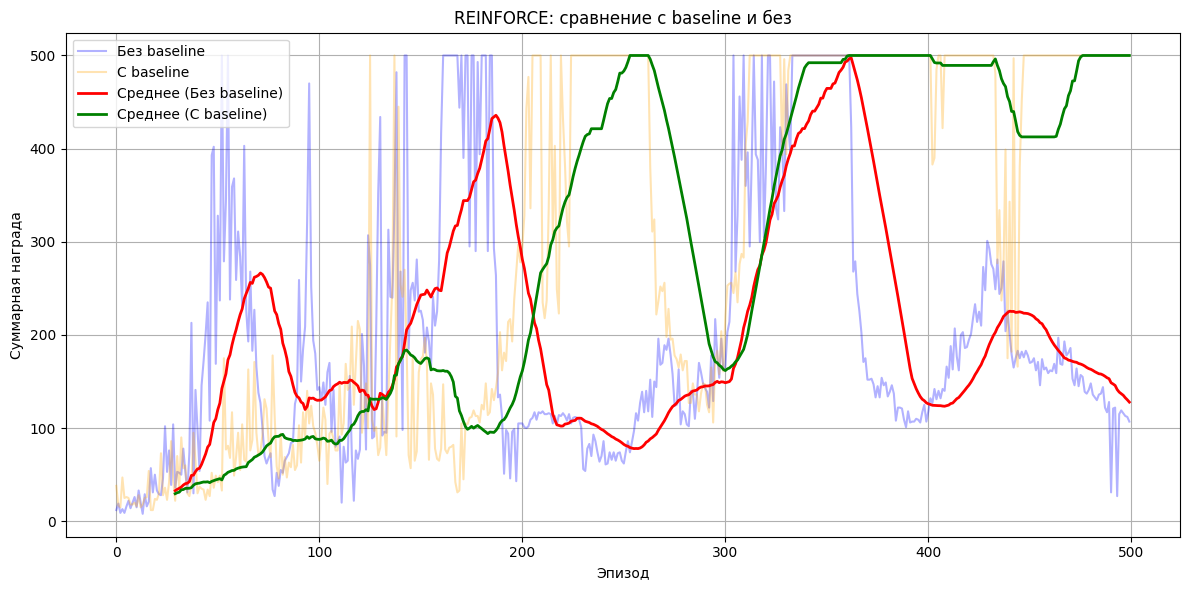

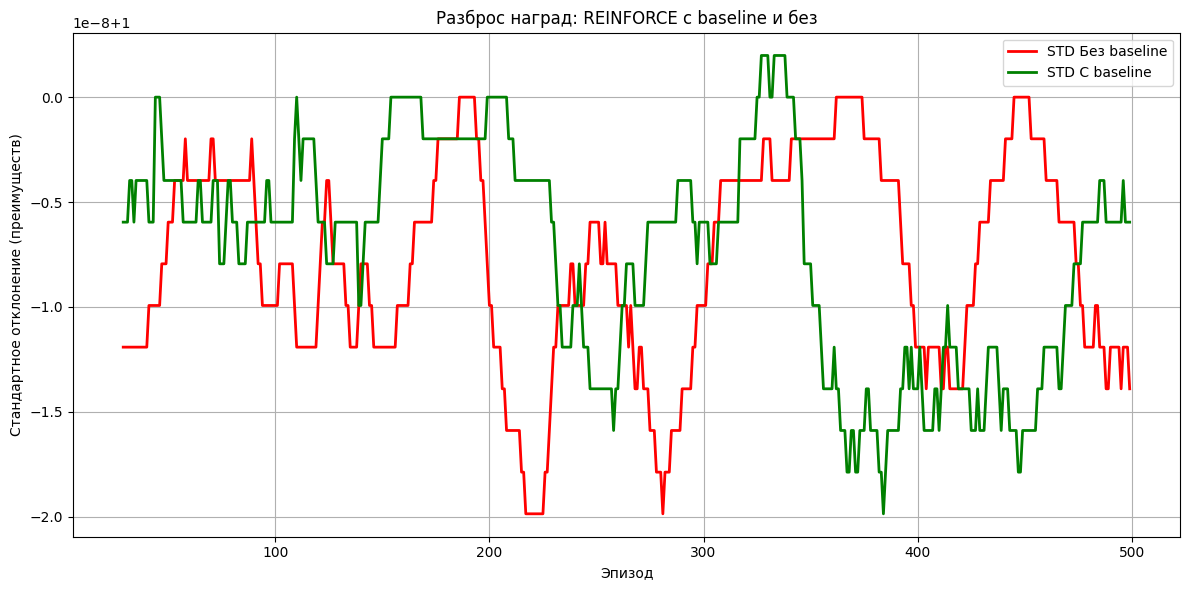

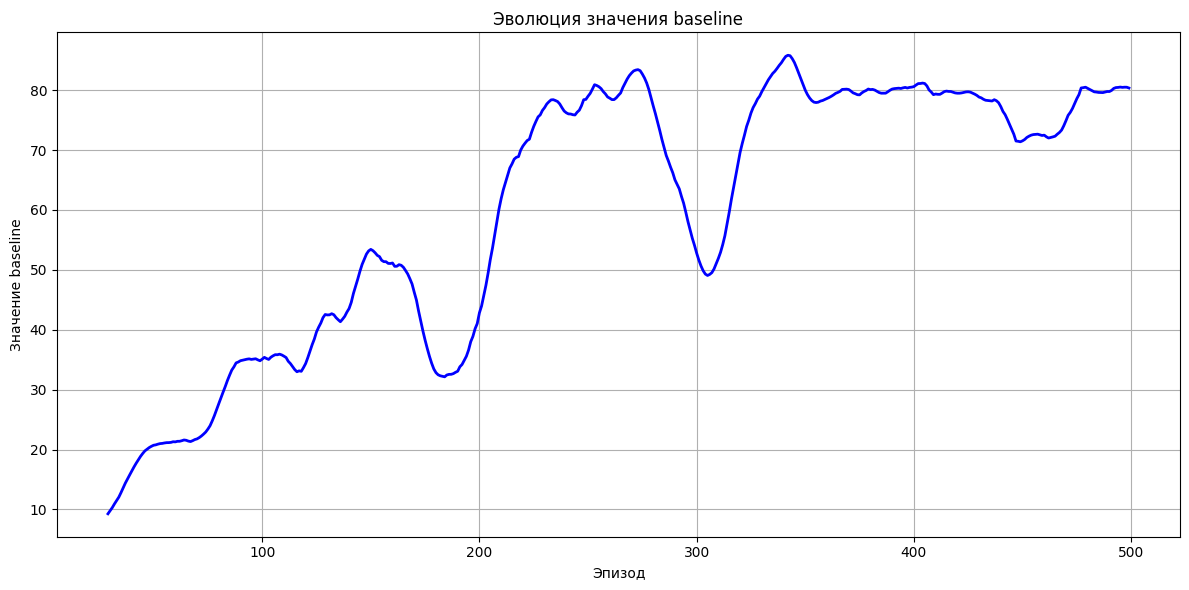


Демонстрация обученной политики с baseline...
Итоговая награда: 500.0


In [9]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

np.bool8 = np.bool_

# --- Установка случайных зерен для воспроизводимости ---
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# --- Политика (нейросеть) ---
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.fc(x)

# --- Базовая сеть для baseline ---
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.fc(x)

# --- Функция для генерации одного эпизода ---
def run_episode(env, policy_net, render=False):
    state = env.reset()[0]
    states = []
    log_probs = []
    rewards = []
    
    while True:
        state_tensor = torch.FloatTensor(state)
        states.append(state_tensor)
        
        # Выбор действия с помощью нейросети
        probs = policy_net(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        # Выполнение действия
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        
        # Сохранение опыта
        log_probs.append(log_prob)
        rewards.append(reward)
        
        if render:
            env.render()
        
        if terminated or truncated:
            break
            
        state = next_state
    
    return states, log_probs, rewards

# --- Вычисление дисконтированных возвратов ---
def compute_returns(rewards, gamma=0.99, normalize=True):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.FloatTensor(returns)
    
    if normalize:
        if len(returns) > 1:  # Проверка чтобы избежать деления на ноль
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    
    return returns

# --- Обычный REINFORCE без baseline ---
def train_reinforce(env, policy_net, optimizer, num_episodes=500, gamma=0.99):
    reward_history = []
    std_history = []
    avg_reward_window = deque(maxlen=100)
    
    for episode in range(num_episodes):
        # Сбор траектории
        states, log_probs, rewards = run_episode(env, policy_net)
        
        # Вычисление возвратов
        returns = compute_returns(rewards, gamma)
        
        # Вычисление потерь и обновление политики
        policy_loss = 0
        for log_prob, G in zip(log_probs, returns):
            policy_loss += -log_prob * G
        
        optimizer.zero_grad()
        policy_loss.backward()
        
        # Клиппинг градиентов для стабильности
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 0.5)
        
        optimizer.step()
        
        # Статистика
        episode_reward = sum(rewards)
        reward_history.append(episode_reward)
        avg_reward_window.append(episode_reward)
        std_history.append(returns.std().item())
        
        if (episode + 1) % 20 == 0:
            avg_reward = np.mean(avg_reward_window)
            print(f"Эпизод {episode + 1}, Награда: {episode_reward:.1f}, Средняя награда (100): {avg_reward:.1f}")
    
    return reward_history, std_history

# --- REINFORCE с baseline (с отдельной сетью для baseline) ---
def train_reinforce_with_baseline(env, policy_net, value_net, policy_optimizer, value_optimizer, num_episodes=500, gamma=0.99):
    reward_history = []
    std_history = []
    baseline_history = []
    avg_reward_window = deque(maxlen=100)
    
    for episode in range(num_episodes):
        # Сбор траектории
        states, log_probs, rewards = run_episode(env, policy_net)
        states_tensor = torch.stack(states)
        
        # Вычисление возвратов (необработанных)
        returns = compute_returns(rewards, gamma, normalize=False)
        
        # Оценка значения состояний с помощью baseline сети
        baseline_values = value_net(states_tensor).squeeze()
        
        # Вычисление преимуществ (advantages)
        advantages = returns - baseline_values.detach()
        
        # Нормализация advantages для стабильности обучения
        if len(advantages) > 1:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)
        
        # 1. Обновление политики
        policy_loss = 0
        for log_prob, advantage in zip(log_probs, advantages):
            policy_loss += -log_prob * advantage
        
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 0.5)
        policy_optimizer.step()
        
        # 2. Обновление baseline (value network)
        value_loss = nn.MSELoss()(baseline_values, returns)
        
        value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(value_net.parameters(), 0.5)
        value_optimizer.step()
        
        # Статистика
        episode_reward = sum(rewards)
        reward_history.append(episode_reward)
        avg_reward_window.append(episode_reward)
        std_history.append(advantages.std().item())
        baseline_history.append(baseline_values.mean().item())
        
        if (episode + 1) % 20 == 0:
            avg_reward = np.mean(avg_reward_window)
            print(f"Эпизод {episode + 1}, Награда: {episode_reward:.1f}, Средняя награда (100): {avg_reward:.1f}, "
                  f"Mean baseline: {baseline_values.mean().item():.2f}")
    
    return reward_history, std_history, baseline_history

# --- Графики ---
def plot_rewards_comparison(rewards1, rewards2, window=100, label1="Без baseline", label2="С baseline"):
    plt.figure(figsize=(12, 6))
    
    # Исходные данные (полупрозрачные)
    plt.plot(rewards1, alpha=0.3, color='blue', label=f"{label1}")
    plt.plot(rewards2, alpha=0.3, color='orange', label=f"{label2}")
    
    # Скользящие средние
    if len(rewards1) >= window:
        avg1 = np.convolve(rewards1, np.ones(window)/window, mode='valid')
        x1 = np.arange(window-1, len(rewards1))
        plt.plot(x1, avg1, label=f"Среднее ({label1})", color="red", linewidth=2)
    
    if len(rewards2) >= window:
        avg2 = np.convolve(rewards2, np.ones(window)/window, mode='valid')
        x2 = np.arange(window-1, len(rewards2))
        plt.plot(x2, avg2, label=f"Среднее ({label2})", color="green", linewidth=2)
    
    plt.xlabel("Эпизод")
    plt.ylabel("Суммарная награда")
    plt.title("REINFORCE: сравнение с baseline и без")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("reinforce_comparison.png")
    plt.show()

def plot_std_comparison(stds1, stds2, window=20, label1="Без baseline", label2="С baseline"):
    plt.figure(figsize=(12, 6))
    
    # Применение скользящего среднего к данным дисперсии
    if len(stds1) >= window:
        avg_stds1 = np.convolve(stds1, np.ones(window)/window, mode='valid')
        x1 = np.arange(window-1, len(stds1))
        plt.plot(x1, avg_stds1, label=f"STD {label1}", color="red", linewidth=2)
    else:
        plt.plot(stds1, label=f"STD {label1}", color="red", linewidth=2)
    
    if len(stds2) >= window:
        avg_stds2 = np.convolve(stds2, np.ones(window)/window, mode='valid')
        x2 = np.arange(window-1, len(stds2))
        plt.plot(x2, avg_stds2, label=f"STD {label2}", color="green", linewidth=2)
    else:
        plt.plot(stds2, label=f"STD {label2}", color="green", linewidth=2)
    
    plt.xlabel("Эпизод")
    plt.ylabel("Стандартное отклонение (преимуществ)")
    plt.title("Разброс наград: REINFORCE с baseline и без")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("reinforce_std_comparison.png")
    plt.show()

def plot_baseline_evolution(baseline_history, window=20):
    plt.figure(figsize=(12, 6))
    
    if len(baseline_history) >= window:
        avg_baseline = np.convolve(baseline_history, np.ones(window)/window, mode='valid')
        x = np.arange(window-1, len(baseline_history))
        plt.plot(x, avg_baseline, color="blue", linewidth=2)
    else:
        plt.plot(baseline_history, color="blue", linewidth=2)
    
    plt.xlabel("Эпизод")
    plt.ylabel("Значение baseline")
    plt.title("Эволюция значения baseline")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("baseline_evolution.png")
    plt.show()

# --- Основной код ---
if __name__ == "__main__":
    # Настройка окружения
    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    num_episodes = 500
    gamma = 0.99
    
    # --- Обучение без baseline ---
    print("Обучение REINFORCE без baseline...")
    policy_net_1 = PolicyNetwork(state_dim, action_dim)
    optimizer_1 = optim.Adam(policy_net_1.parameters(), lr=0.005)
    rewards1, stds1 = train_reinforce(env, policy_net_1, optimizer_1, num_episodes=num_episodes, gamma=gamma)
    
    # --- Обучение с baseline ---
    print("\nОбучение REINFORCE с baseline...")
    policy_net_2 = PolicyNetwork(state_dim, action_dim)
    value_net = ValueNetwork(state_dim)
    policy_optimizer = optim.Adam(policy_net_2.parameters(), lr=0.005)
    value_optimizer = optim.Adam(value_net.parameters(), lr=0.01)
    rewards2, stds2, baseline_history = train_reinforce_with_baseline(
        env, policy_net_2, value_net, policy_optimizer, value_optimizer, 
        num_episodes=num_episodes, gamma=gamma
    )
    
    # --- Графики ---
    plot_rewards_comparison(rewards1, rewards2, window=30)
    plot_std_comparison(stds1, stds2, window=30)
    plot_baseline_evolution(baseline_history, window=30)
    
    # --- Демонстрация обученной политики ---
    print("\nДемонстрация обученной политики с baseline...")
    _, _, rewards_test = run_episode(env, policy_net_2, render=False)
    print(f"Итоговая награда: {sum(rewards_test)}")

In [13]:
save('pg_res', 'CartPole-v1')

''CartPole-v1')' was not found in history, as a file, url, nor in the user namespace.


Эпизод 50, Награда: 13.0, Средняя награда: 22.6
Эпизод 100, Награда: 17.0, Средняя награда: 22.8
Эпизод 150, Награда: 30.0, Средняя награда: 23.1
Эпизод 200, Награда: 12.0, Средняя награда: 25.9
Эпизод 250, Награда: 26.0, Средняя награда: 27.4
Эпизод 300, Награда: 15.0, Средняя награда: 26.2
Эпизод 350, Награда: 14.0, Средняя награда: 27.5
Эпизод 400, Награда: 12.0, Средняя награда: 24.7
Эпизод 450, Награда: 15.0, Средняя награда: 27.3
Эпизод 500, Награда: 13.0, Средняя награда: 29.1
